In [1]:
!pip install torch
!pip install torchvision

  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)


In [30]:
# Essential Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# Intermediate block
# Consists of a number of L convolutional layers and a FC layer
# FC layers takes as input the mean across all input channels, passes it through a linear network and softmax function to generate L scalars
# The outputs from L convolutional layers is weighted by the L scalars and summed to give the output

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers, pool = False):
        ''' @params
            in_channels : int -> No. of channels in the input image
            out_chanells : int -> No. of channels in the output image
            num_conv_layers : int -> No. of convolutional layers in each block
            pool : bool -> Boolean to apply a pooling layer to the convolution output
        '''
        super(IntermediateBlock, self).__init__()        # call constructor of base class(nn.module)
        self.num_conv_layers = num_conv_layers           # Define number of convolution layers in the block

        # Convolutional layers definition
        # Sequential Module : conv2D -> BatchNorm -> ReLU Activation -> Pooling -> Dropout
        # All blocks use 3x3 kernel with padding = 1 to maintain input image shape in the output
        # If pool = False then replace maxpool layer with identity block to maintain flow of code
        # dropout layer added to prevent overfitting
        self.convs=nn.ModuleList([
            nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) if pool else nn.Identity(),
            nn.Dropout(p=0.5)
            )
            for _ in range(num_conv_layers)
        ])

        #Adaptive pooling layer to calculate the channel means of the image and return a tensor of length num_conv_layers
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Linear layer to compute feature map from input image channel means and generate a scalar of size num_conv_layers to weigh convolution outputs
        self.fc = nn.Linear(in_channels, num_conv_layers)


    def forward(self, x):
        # Feed forward definition

        channel_means = self.adaptive_pool(x)                              # Compute means across each channel of input image
        channel_means_reshaped = channel_means.squeeze(-1).squeeze(-1)     # reshaped to shape: [batch_size, in_channels]
        
        # # Compute the softmax weights for each convolutional layer's output
        a = torch.softmax(self.fc(channel_means_reshaped), dim=1)
        
        conv_outputs = [conv(x) for conv in self.convs]  # forward definition of all convolution layers
        conv_outputs = torch.stack(conv_outputs, dim=1)  # stack outputs into a tensors of shape: [batch_size, num_conv_layers, channels, H, W]

        # Reshape global feature map for multiplication across the conv output dimensions
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)                    # shape: [batch_size, num_conv_layers, 1, 1, 1]
        
        # Element-wise multiplication of weights and convolution layer outputs and sum
        output_image = (a * conv_outputs).sum(dim=1)                       # shape: [batch_size, channels, H, W]

        return output_image
            

In [40]:
# Output block to compute the final class prediction of the model 
# Computes the gobal average pooling of the block outputs and passes it through 2 FC layers to output 10 values each pertaining to one class label
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))    # Global Average Pool
        self.fc1 = nn.Linear(in_channels, 128)                 # Fully connected layer 1 - takes no. of channels from block output as in_channels. Output 128 features
        self.relu=nn.ReLU(inplace=True)                        # Activation
        self.dropout=nn.Dropout(0.2)                           # Dropout layers to reduce overfitting and help model generalize better
        self.fc2 = nn.Linear(128, num_classes)                 # Fully connected layer 2 - in_features = 128 from previous layer, Output 10 features
        
    def forward(self, x):
        # Feed forward definition of output block
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        o = self.fc2(x)
        return o

In [41]:
# Main CIFAR-10 model built using the intermediate blocks and the output blocks

class CustomCIFAR10Model(nn.Module):
    def __init__(self, num_blocks, block_channels, num_classes=10):
        ''' @Params
            num_blocks : int -> No. of intermediate blocks in the main networks
            block_channels : list : (out_channels, num_layers, pool) -> list of configurations for each block
                    out_channels : No. of channels required in the block output image
                    num_layers : No. of convulotional layers in block
                    pool : bool to apply pooling in that particular block
            num_classes : int -> No. of classes to be predicted. Defaults to 10 sicne CIFAR - 10 has 10 class labels 
        '''
        super(CustomCIFAR10Model, self).__init__()    # Call constructor of base class
        self.blocks = nn.ModuleList()                 # Module to store intermediate blocks
        in_channels = 3                               # CIFAR-10 images have 3 channels

        # Loop through input block list and append blocks to class moduleList
        for i in range(num_blocks):
            out_channels, num_layers, pool = block_channels[i]
            self.blocks.append(IntermediateBlock(in_channels, out_channels, num_layers, pool))
            in_channels = out_channels                # Update the in_channel to out_channel of previous block to handle the next block
        
        self.output_block = OutputBlock(in_channels, num_classes)     # Initialise output block
        
    def forward(self, x):
        # Feed forward definition of main model
        for block in self.blocks:
            x = block(x)
        logits = self.output_block(x)
        return logits

In [42]:
# Check availability of CUDA support

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")

    # Empty CPU cache
    torch.cuda.empty_cache()

else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

# torch.cuda.memory_summary(device=None, abbreviated=False)

GPU is available!


In [40]:
# Data loading and transformation setup.
# Note : This loader is just to obtain the mean and standard deviance of all images in the training set
# We are using the mean and std to normalize the images before passing it to the model
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Calculate mean and stard deviation of CIFAR 10 dataset
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Sum up all the values for each channel
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        # Sum up the squares of all the values for each channel
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    # Calculate the mean and standard deviation
    mean = channels_sum / num_batches
    # Variance = E[X^2] - (E[X])^2
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = calculate_mean_std(train_loader)

print(f'Mean: {mean}')
print(f'Std: {std}')

Files already downloaded and verified
Files already downloaded and verified
Mean: tensor([0.4914, 0.4821, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [43]:
# Data loading and transformation setup. Create a new dataloader with the image augmentation applied to normalize using mean & std calculated previously
# Randomly flip a percentage of images horizontally -> This helps the model generalize better by learning features oriented differently  
# loader batch sizes set to 128
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247, 0.243, 0.261))
                               ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [44]:

# Model, loss, and optimizer
# Define number of epochs, learning rate, loss function, optimizer and scheduler
epochs = 90
lr = 0.001   # Learning Rate

model = CustomCIFAR10Model(num_blocks=6, block_channels=[(16, 3, False), (32, 3, False), (64,3, True), (128,3, True), (256,3, True), (512,3, True)], num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.3)

print(f'total number of parameters in the network: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e3:.2f}K')

total number of parameters in the network: 4792.82K


In [45]:
model

CustomCIFAR10Model(
  (blocks): ModuleList(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Identity()
          (4): Dropout(p=0.5, inplace=False)
        )
      )
      (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=3, bias=True)
    )
    (1): IntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Identity()
          (4): Dropout(p=0.5, inplace=False)
        )
      )
      (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_

In [46]:

# Training loop

train_accuracies = []            # List to capture training accuracy per epoch 
test_accuracies = []             # List to capture testing accuracy per epoch 
lr_epochs = []                   # List to capture learning rate change per epoch
train_loss = []                  # List to capture training loss per epoch as the avg of the of all batch LRs in each epoch 
test_loss = []                   # List to capture testing loss per epoch 

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0
    lr_batch = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # getting the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Obtain losses and backpropagate
        loss = criterion(outputs, labels)
        total_loss += loss
        loss.backward()
        optimizer.step()

        # Step the scheduler and save the current learning rate for plotting
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        lr_batch.append(current_lr)


    # After all mini-batches in the epoch, calculate and print the overall accuracy
    train_loss_avg = total_loss/ len(train_loader)
    train_loss.append(train_loss_avg.cpu().item())
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    #Average Learning rates from each batch to obtain Learning Rate for epoch
    avg_batch_lr = np.mean(lr_batch)
    lr_epochs.append(avg_batch_lr)

    # Testing loop
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    test_loss_avg = total_loss/ len(test_loader)
    test_loss.append(test_loss_avg)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss_avg:.4f}, Learning Rate: {current_lr}')

Epoch 1/90, Train Loss: 1.6327, Train Accuracy: 39.19%, Test Accuracy: 33.55%, Test Loss: 2.0121, Learning Rate: 0.0004324589539343709
Epoch 2/90, Train Loss: 1.2592, Train Accuracy: 54.35%, Test Accuracy: 58.11%, Test Loss: 1.1590, Learning Rate: 0.0005293968225331003
Epoch 3/90, Train Loss: 1.0907, Train Accuracy: 61.28%, Test Accuracy: 61.24%, Test Loss: 1.0986, Learning Rate: 0.0006895025633747998
Epoch 4/90, Train Loss: 0.9770, Train Accuracy: 65.77%, Test Accuracy: 66.77%, Test Loss: 0.9265, Learning Rate: 0.0009106108160983773
Epoch 5/90, Train Loss: 0.8945, Train Accuracy: 68.99%, Test Accuracy: 71.74%, Test Loss: 0.8188, Learning Rate: 0.001189731187958145
Epoch 6/90, Train Loss: 0.8444, Train Accuracy: 70.57%, Test Accuracy: 75.96%, Test Loss: 0.6904, Learning Rate: 0.0015230886975822894
Epoch 7/90, Train Loss: 0.7999, Train Accuracy: 72.31%, Test Accuracy: 76.70%, Test Loss: 0.6692, Learning Rate: 0.001906174829950577
Epoch 8/90, Train Loss: 0.7718, Train Accuracy: 73.30%, T

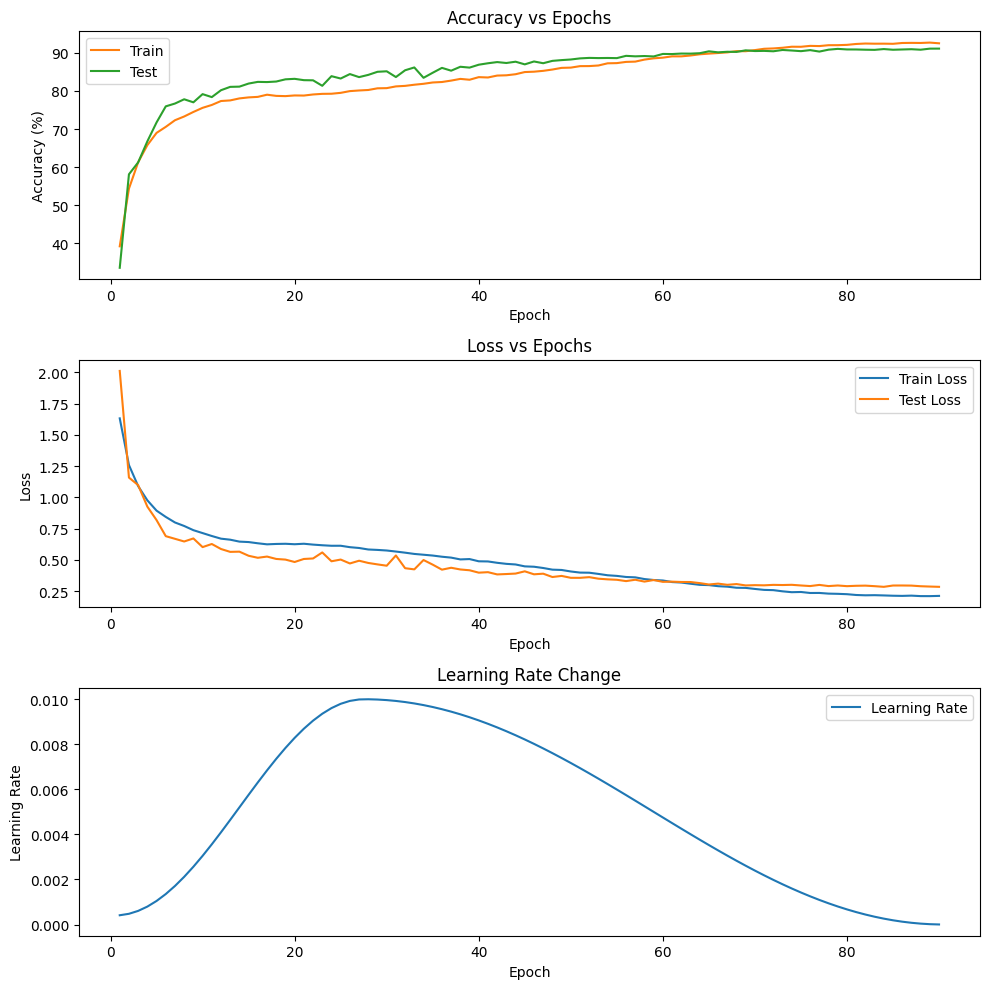

In [47]:
# Plotting the training and testing accuracy, loss and learning rate change per epoch

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy vs Epochs')
ax1.plot(range(1, epochs+1), train_accuracies, label='Train', color='tab:orange')
ax1.plot(range(1, epochs+1), test_accuracies, label='Test', color='tab:green')
ax1.tick_params(axis='y')
ax1.legend()

# Plot losses
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs Epochs')
ax2.plot(range(1, epochs+1), train_loss, label='Train Loss')
ax2.plot(range(1, epochs+1), test_loss, label='Test Loss')
ax2.legend()

# Plot learning rates
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Change')
ax3.plot(range(1, epochs+1), lr_epochs, label='Learning Rate')
ax3.legend()

fig.tight_layout()
plt.show()

In [12]:
# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 91.1 %
